# Capstone 2: Personality Prediction MBIT

## Proposal
Have you ever been curious about the personality type of yourself and people around 
you? Is there any simple test to help us find the answer? The answer is yes. You can figure out your personality type by simply answering these four questions:

* Are you outwardly or inwardly focused ? 
* How do you prefer to take in information? 
* How do you prefer to make decisions? 
* How do you prefer to live your outer life?

For each question, there are two options to choose from. You choose the side that seems most  natural for you. The options are: Introversion (**I**) or Extraversion (**E**), Sensing (**S**) or Intuition (**N**), Thinking (**T**) or Feeling (**F**) and Judging (**J**) or Perception (**P**) respectively. The introspective self-report questionnaire we introduced above is known as Myers-Briggs -Type- Indicator (MBTI). It is a personality type system that divides everyone into 16 distinct personalities based one their answers to the previous questions. For example, someone who chooses extraversion, sensing, thinking and judging would be labeled an ESTP in the MBTI system. 

This project focuses on using machine learning algorithms to predict the personality of a person from the type of posts they put on social media. The data was collected through the PersonalityCare forum and is available on Kaggle [Personality Prediction Dataset](https://www.kaggle.com/datasnaek/mbti-type). This dataset consists of over 8675 rows representing 8675 different people and 2 columns representing a person’s MBTI personality type and the things they have posted.


## Exploratory Data Analysis

In [1]:
pip install pip --upgrade

     |████████████████████████████████| 1.5 MB 985 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U gensim

Requirement already up-to-date: gensim in /opt/anaconda3/lib/python3.7/site-packages (3.8.3)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import numpy as np
import collections
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Loading Data

We first load the data to a DataFrame using **pd.read_csv** and look at the structure of the data set.

In [7]:
df = pd.read_csv('/Users/vnguyenair/Desktop/springboard/vy_capstone2_Personality_Prediction/mbti_1.csv',low_memory=False)
df.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


The data has two columns **type** and **posts** and no missing data. The two columns represent the personality type of 8675 different people and their corresponding posts on social media. The personality type is expressed by 4 letters representing the answers for 4 questions above. The first letter can either be **I**(Introversion) or **E**(Extraversion). The second one can either be **S**(sensing) or **N**(Intuition). The third one can either be **T**(Thinking) or **F**(Feeling). The last letter can either be **J**(Judging) or **P**(Perception). The first person in our table has personality type **INFJ** implying Introversion-Intuition-Feeling-Judging.

Before doing any NLP, we analyze the data set using common sense. It is natural to think that the length of a post, number of questionmark, exclamation, ellipsis or images in a post somehow reveal the personality of the owner. We are going to find these numbers and add columns **post_length**, **question_per_post**, **excl_per_post**, **ellipsis_per_post**, **img_per_post** to our data **df**.

In [9]:
df['post_length'] = df['posts'].apply(lambda x: len(x.split()))
df['question_per_post'] = df['posts'].apply(lambda x: x.count('?'))
df['img_per_post'] = df['posts'].apply(lambda x: x.count('jpg'))
df['excl_per_post'] = df['posts'].apply(lambda x: x.count('!'))
df['ellipsis_per_post'] = df['posts'].apply(lambda x: x.count('...'))

In [10]:
df.head()

type                                              posts  post_length  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...          556   
1  ENTP  'I'm finding the lack of me in these posts ver...         1170   
2  INTP  'Good one  _____   https://www.youtube.com/wat...          836   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...         1064   
4  ENTJ  'You're fired.|||That's another silly misconce...          967   

   question_per_post  img_per_post  excl_per_post  ellipsis_per_post  
0                 18             6              3                 15  
1                  5             1              0                 19  
2                 12             0              4                 13  
3                 11             0              3                 26  
4                 10             2              1                 21

### Analyze Data

There are 16 personality types. How are they distributed in our data? We first want to explore the distribution of different kind of personality types. 

We are going to use the **value_counts()** method for series **df['type']**. The return series **typ** contains counts of unique values of **type**. The resulting types will be in descending order. The **sns.barplot()** function is used to create a bar chart representing the distribution of different kind of personality.

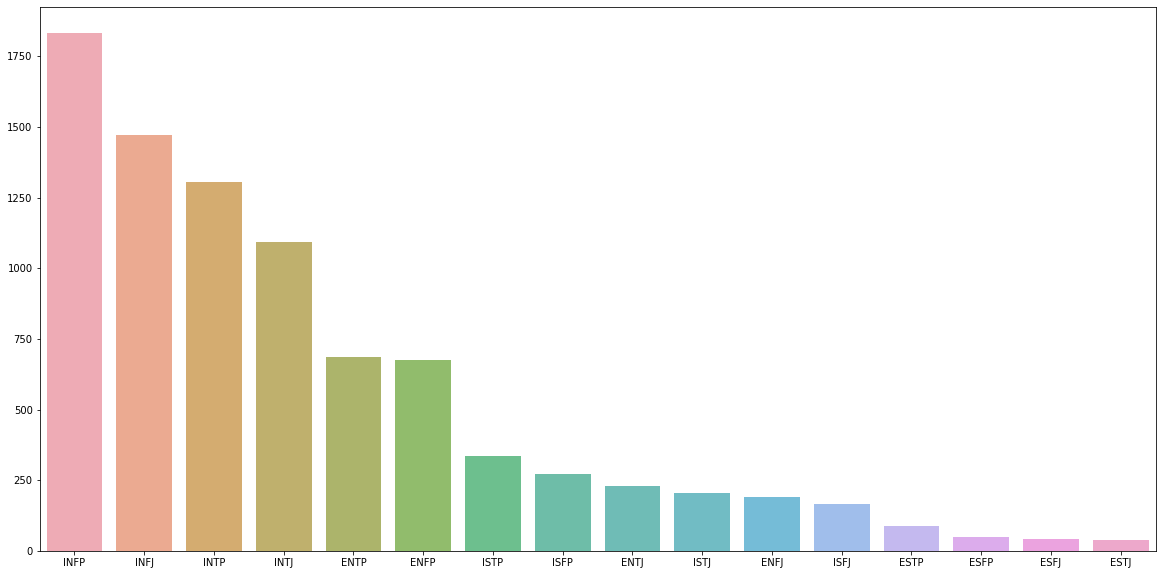

In [11]:
typ = df['type'].value_counts()

plt.figure(figsize=(20,10))
sns.barplot(typ.index, typ.values, alpha=0.8)

It is obvious that the distribution is unbalanced between different classes. The group INFP(Introversion-Intuition-Feeling-Perception)has the highest frequency while the group ESTJ (Extraversion-Sensing-Thinking-Judging) has the lowest frequency. 

We use **groupby()** and **count()** functions to count exact number of posts in each personality type.

In [12]:
df[['type','posts']].groupby('type').count().sort_values(by='posts', ascending=False)

posts
type       
INFP   1832
INFJ   1470
INTP   1304
INTJ   1091
ENTP    685
ENFP    675
ISTP    337
ISFP    271
ENTJ    231
ISTJ    205
ENFJ    190
ISFJ    166
ESTP     89
ESFP     48
ESFJ     42
ESTJ     39

 The largest group is **INFP** (Introversion-Intuition-Feeling-Perception) with 1832 posts, while the smallest group is **ESTJ** (Extraversion-Sensing-Thinking-Judging) with only 39 posts. We observe that the majority of posts (5697) in our data belong to **IN** (Introversion-Intuition) people while the **ES**(Extraversion_Sensing) people contribute only 218 posts. The difference in frequencies is really significant. The group with highest frequency is almost triple the group with 5th highest frequency, and 46 times more than the group with the lowest frequency.


Let's look at the distribution of the length of post.

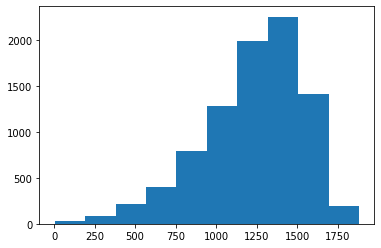

In [13]:
plt.hist(df['post_length'])
plt.show()

The majority of posts in our data are more than 500 words. 

We now look at the relations between the type of personality and the length of post, as well as the number of questionmarks, exclamations, ellipsis and images per post.

In [14]:
df[['type','post_length']].groupby('type').mean().sort_values(by='post_length', ascending=False)

post_length
type             
ESFJ  1290.476190
ENFJ  1286.584211
INFJ  1278.431973
ENFP  1260.770370
INFP  1244.552948
ISFJ  1241.295181
ESTJ  1229.538462
ENTJ  1218.086580
ISTJ  1213.224390
ENTP  1205.995620
INTP  1197.763037
INTJ  1194.577452
ISTP  1165.563798
ESTP  1162.595506
ISFP  1136.383764
ESFP  1022.125000

The **ESFJ** (Extraversion-Sensing-Feeling-Judging) tends to have longest post( average 1290 words per post) while the **ESFP** (Extraversion-Sensing-Feeling-Perception) tends to have shortest post (average 1022 words per post ).

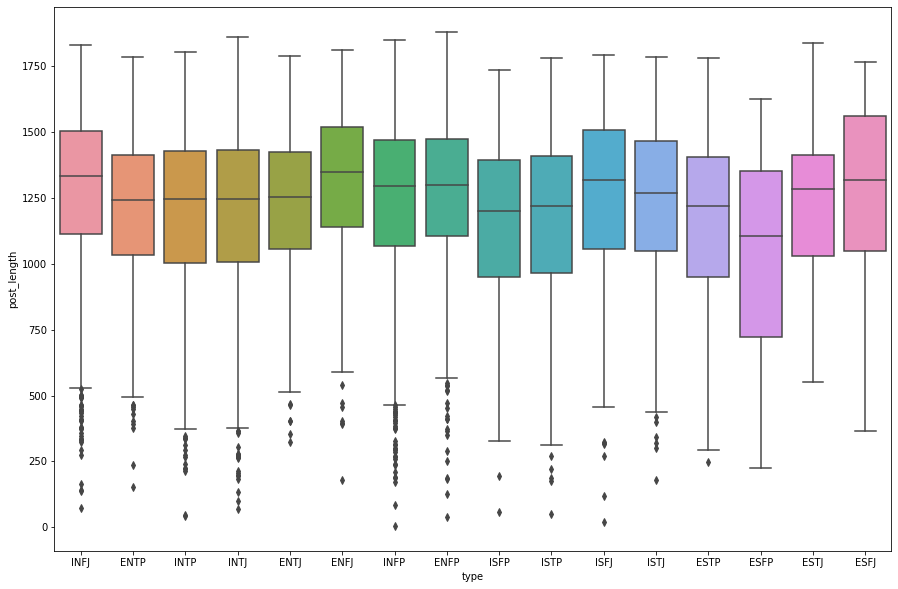

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "post_length", data=df)

In [15]:
df[['type','question_per_post']].groupby('type').mean().sort_values(by='question_per_post', ascending=False)

question_per_post
type                   
ESTP          12.292135
ENTJ          12.000000
ESFP          11.854167
ENFP          11.362963
ISTP          11.080119
INTP          11.078988
ENTP          11.048175
ISFP          10.819188
ISTJ          10.746341
INTJ          10.742438
ENFJ          10.652632
ESTJ          10.487179
INFJ          10.448299
INFP          10.126638
ISFJ          10.048193
ESFJ           8.809524

People from the **ESTP** (Extraversion-Sensing-Thinking-Perception) tend to use more question marks in their post (average 12.3 question marks per post) while people in the **ESFJ** (Extraversion-Sensing-Feeling-Judging) tend to use less question marks in their posts (average 8.8 question marks per post). The difference in question marks between groups is not significant comparing to the length of these posts.

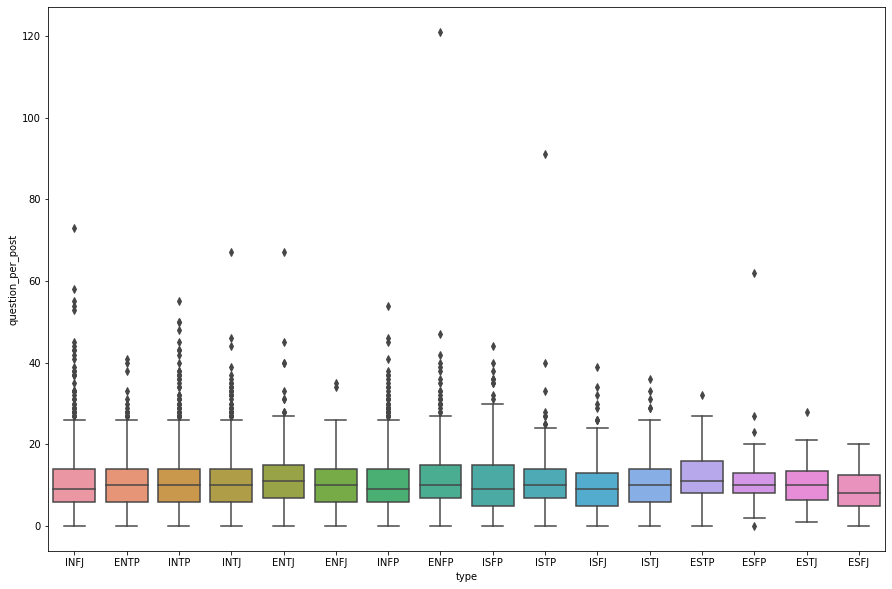

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "question_per_post", data=df)

The groups **ENFP** (Extraversion-Intuition-Feeling-Perception), **ISTP** (Introversion-Sensing-Thinking-Perception) and **ESFP** (Extraversion-Sensing-Feeling-Perception) have outliers in the number of quesion marks.

In [16]:
df[['type','excl_per_post']].groupby('type').mean().sort_values(by='excl_per_post', ascending=False)

excl_per_post
type               
ENFP      16.939259
ENFJ      13.800000
ESFJ      11.523810
ESFP      10.958333
ISFJ      10.475904
ISFP      10.398524
INFP       9.322052
INFJ       9.077551
ENTJ       8.298701
ESTJ       8.205128
ESTP       8.000000
ISTJ       7.980488
ENTP       7.129927
INTJ       5.262145
INTP       5.004601
ISTP       4.629080

The group **ENFP** (Extraversion-Intuition-Feeling-Perception) use the most exclamation ( Average 16.9 exclamation per post) while the group **ISTP** (Introversion-Sensing-Thinking-Perception) use the least exclamation (average 4.6 exclamation per post).

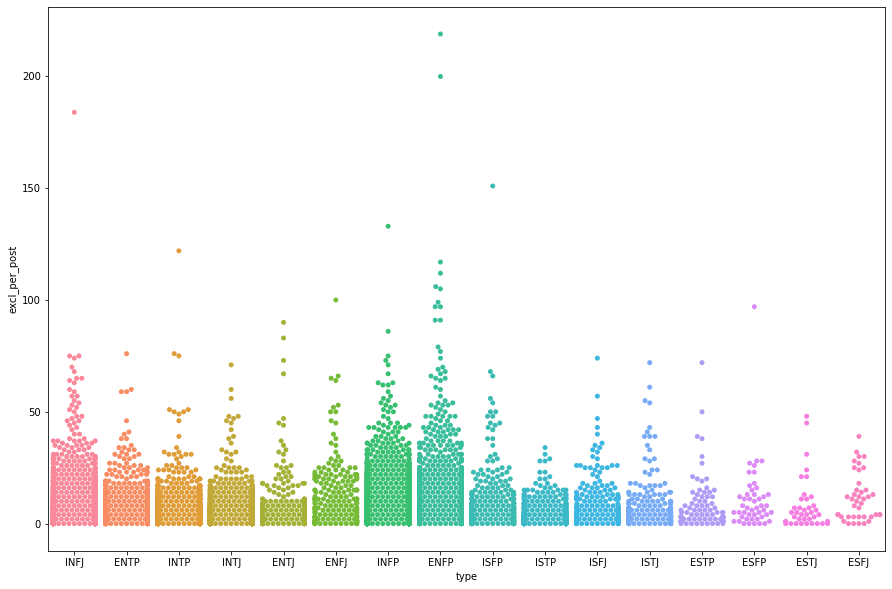

In [16]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "excl_per_post", data=df)

In [17]:
df[['type','ellipsis_per_post']].groupby('type').mean().sort_values(by='ellipsis_per_post', ascending=False)

ellipsis_per_post
type                   
ENFJ          37.221053
INFJ          36.071429
ENFP          35.794074
INFP          33.829694
ISFJ          33.072289
ENTJ          32.333333
ESFJ          31.928571
ISTJ          31.917073
INTP          31.608896
ENTP          31.551825
ESTJ          31.538462
INTJ          31.527039
ISFP          29.808118
ISTP          29.347181
ESTP          28.876404
ESFP          26.687500

The group **ENFJ** (Extraversion-Intuition-Feeling-Judging) use the most ellipsis ( Average 37.2 ellipsis per post) while the group **ESFP** (Extraversion-Sensing-Feeling-Perception) use the least ellipsis (average 26.7 ellipsis per post).

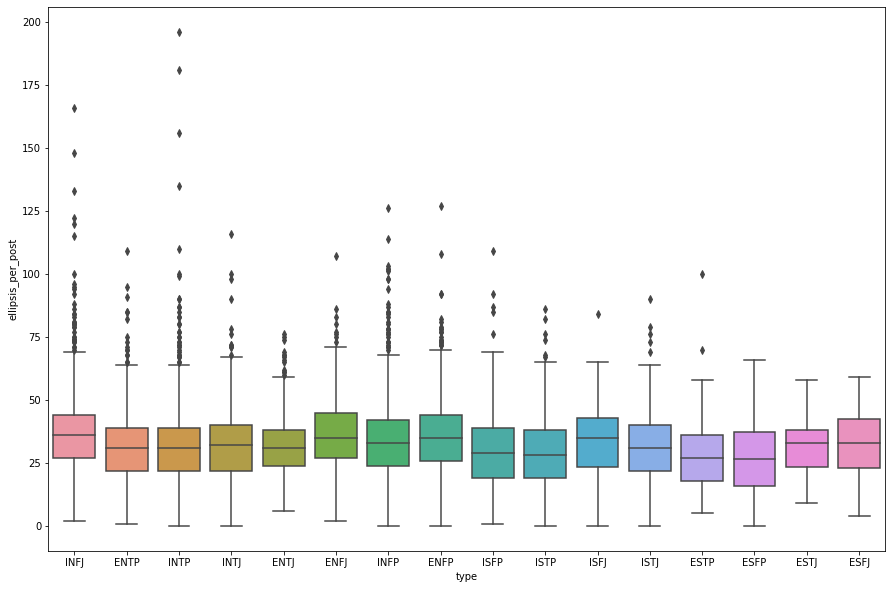

In [18]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "ellipsis_per_post", data=df)

In [18]:
df[['type','img_per_post']].groupby('type').mean().sort_values(by='img_per_post', ascending=False)

img_per_post
type              
ESTP      0.876404
INTP      0.786043
INFP      0.776747
INTJ      0.735105
ISFP      0.730627
ISTP      0.700297
ISFJ      0.698795
ISTJ      0.668293
ENTJ      0.649351
ENTP      0.636496
INFJ      0.628571
ESFP      0.625000
ESTJ      0.615385
ENFJ      0.578947
ENFP      0.527407
ESFJ      0.333333

The difference of the number of pictures between groups is not significant comparing to their length.

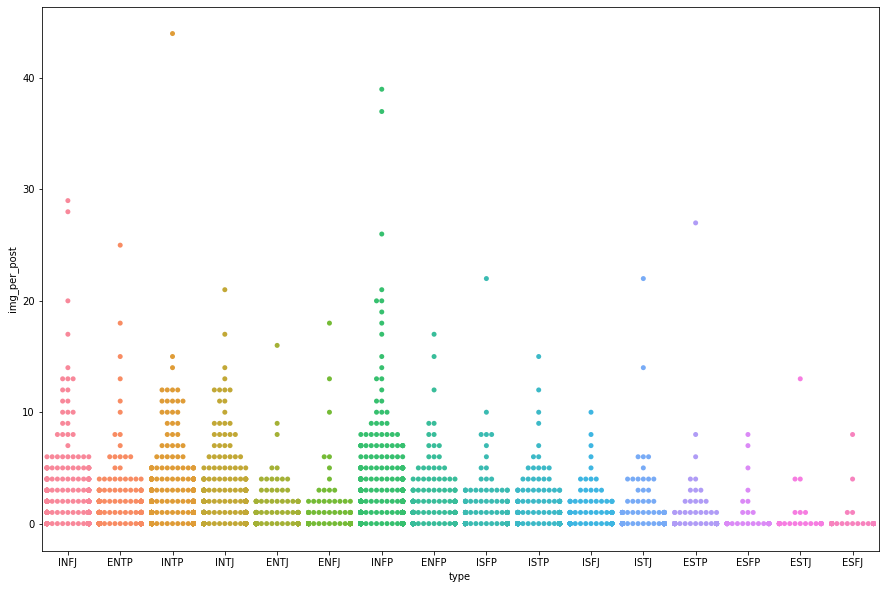

In [18]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "img_per_post", data=df)

## Preprocess the Data

In this session, we are going to preprocess the data and make it ready for machine learning models.

In [19]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS

In the next step, we are going to create 3 functions which play important role in preprocessing text. They are : **clean_text**, **combine_text** and **text_preprocessing**.

* **clean_text** function takes the argument text, the make the text lowercase, remove text in square braktes, remove links, remove punctuation and remove words containing numbers.
* **text_preprocessing** function takes text as an argument. It first applies the function clean_text on the argument, tokenize the result, remove all stop words before combine all tokens.
* **combine_text** function combine single words into text.

In [27]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def combine_text(text):
    return ' '.join(text)

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer("[\w']+")
    no_punc = clean_text(text)
    tokenized_text = tokenizer.tokenize(no_punc)
    remove_stopwords = [w for w in tokenized_text if w not in STOPWORDS]
    combined_text = combine_text(remove_stopwords)
    
    return combined_text

We are going to create a new collumn for our DataFrame. It called **clean_posts**. It contains the corresponding posts which has been preprocessing.

In [28]:
df['clean_posts'] = df['posts'].apply(lambda x: text_preprocessing(x))

In [29]:
print(df['posts'][:10])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
5    '18/37 @.@|||Science  is not perfect. No scien...
6    'No, I can't draw on my own nails (haha). Thos...
7    'I tend to build up a collection of things on ...
8    I'm not sure, that's a good question. The dist...
9    'https://www.youtube.com/watch?v=w8-egj0y8Qs||...
Name: posts, dtype: object


In [30]:
print(df['clean_posts'][:10])

0    ' intj moments sportscenter top ten plays pran...
1    'i'm finding lack posts alarming sex boring po...
2    'good one _____ course say know blessing curse...
3    'dear intp enjoyed conversation day esoteric g...
4    'you're fired another silly misconception appr...
5    ' science perfect scientist claims scientific ...
6    'no draw nails haha done professionals nails y...
7    'i tend build collection things desktop use fr...
8    sure good question distinction two dependant p...
9    ' position actually let go person due various ...
Name: clean_posts, dtype: object


### Most Used Words Overall

We would like to know out of all clean posts, which words are most used. 

In order to do that, we first create a function **create_corpus**. This function combines all posts from the clean_posts column of its argument which is a dataframe into a corpus.

In [31]:
def create_corpus(df):
    corpus = []
    for text in df.clean_posts.str.split():
        for i in text:
            corpus.append(i)
    return corpus

In [32]:
corpus = create_corpus(df)
corpus = nltk.FreqDist(corpus)

Apply function **create_corpus** to our data **df**. It returns corpus containing all clean_posts. Pass the corpus to **nltk.FreqDist**. It returns words from the corpus and their frequencies.

Let find out the most 20 used words in the whole corpus and look at the visulization in a histogram and a wordcloud map.

In [33]:
print('Total number of words:{}'.format(len(corpus)))
print('Most common words:{}'.format(corpus.most_common(20)))

Total number of words:106794
Most common words:[('think', 49346), ('people', 46217), ('know', 36436), ('one', 36076), ('really', 34895), ('time', 27258), ('feel', 23068), ('much', 22835), ('well', 22565), ('love', 20693), ('good', 20427), ('things', 20273), ('say', 20064), ('way', 19440), ('something', 19258), ('want', 19191), ('see', 18914), ('will', 18643), ('type', 16872), ('now', 16795)]


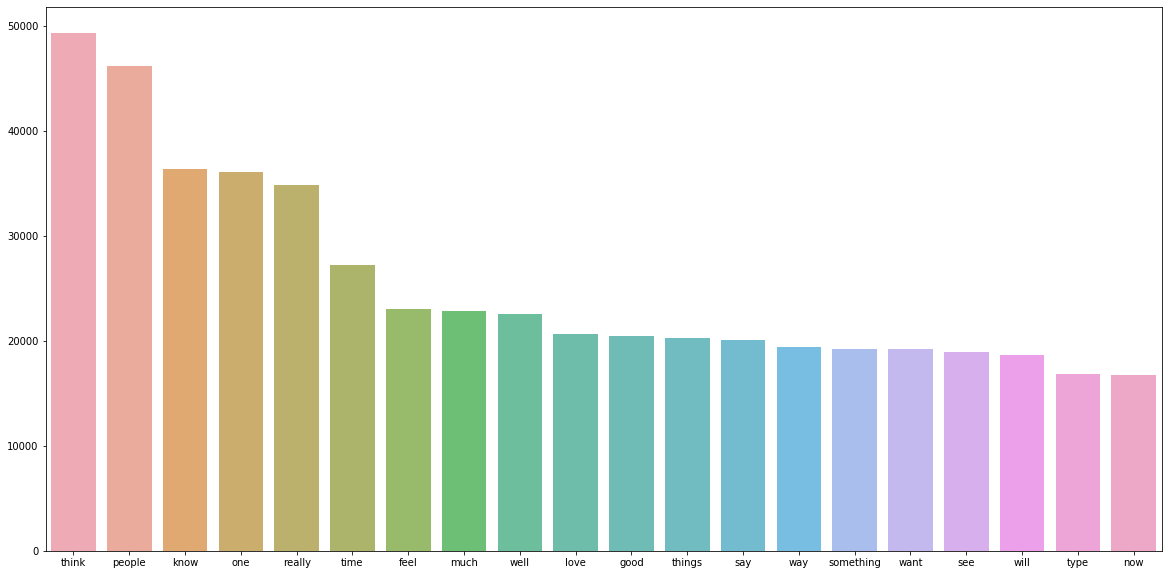

In [34]:
corpus_most_common = corpus.most_common(20)
x = [t[0] for t in corpus_most_common]
y = [t[1] for t in corpus_most_common]
plt.figure(figsize=(20,10))
sns.barplot(x, y, alpha=0.8)

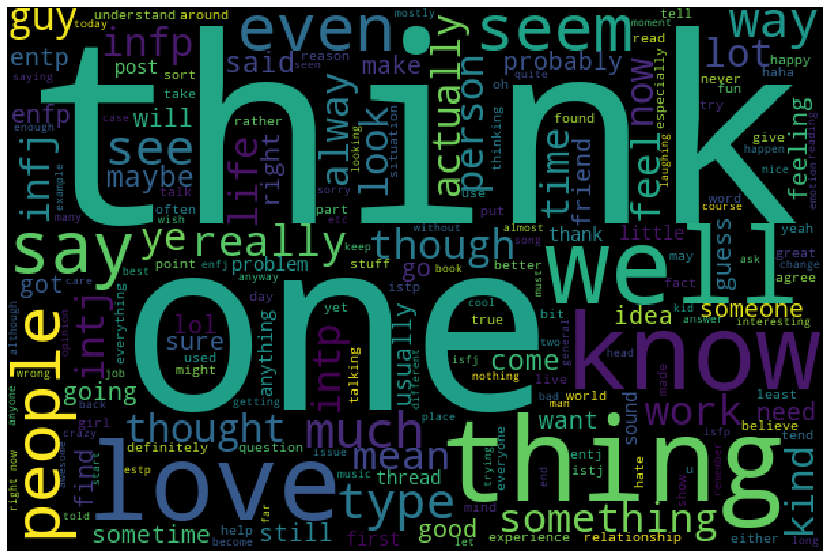

In [35]:
wordcloud = WordCloud(background_color = 'black' , width = 600 , height = 400).generate(" ".join(df['clean_posts']))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Most Used Words in each Group

We now use the same process to find out the most 20 used words in each personality group.

In [36]:
def category_top20(df,category):
    dx = df[df.type == category]
    corpus = create_corpus(dx)
    corpus = nltk.FreqDist(corpus)
    corpus_top20 = corpus.most_common(20)
    x = [t[0] for t in corpus_top20]
    y = [t[1] for t in corpus_top20]
    plt.figure(figsize = (15,5))
    sns.barplot(list(x) , list(y)).set(title = 'Frequency of Top 20 words in this '+ category)

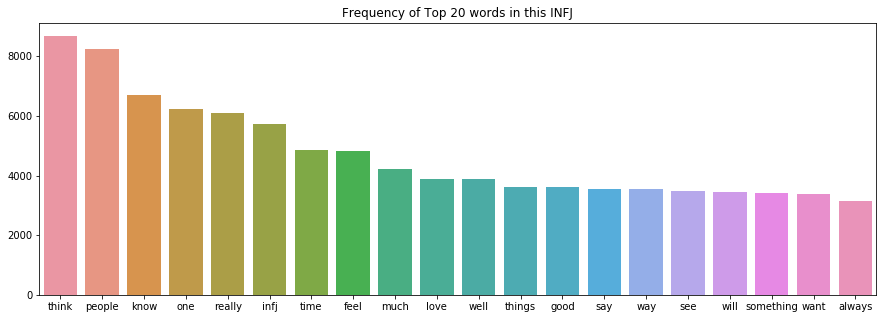

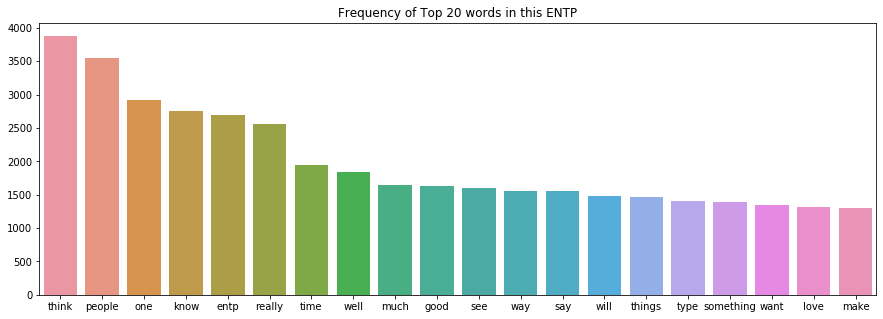

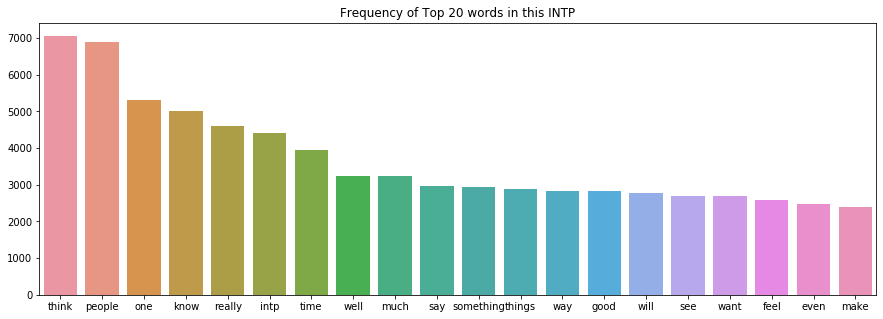

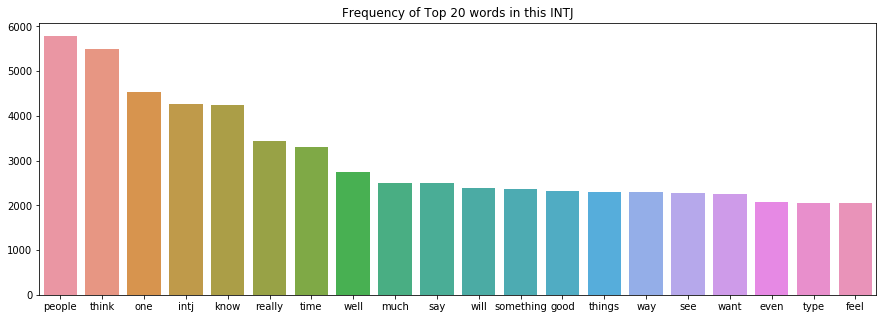

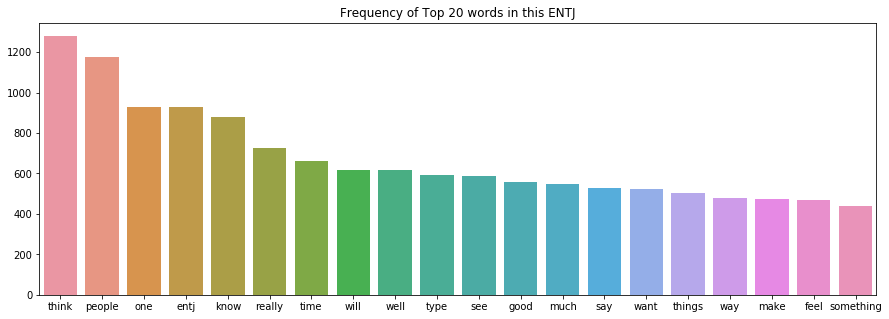

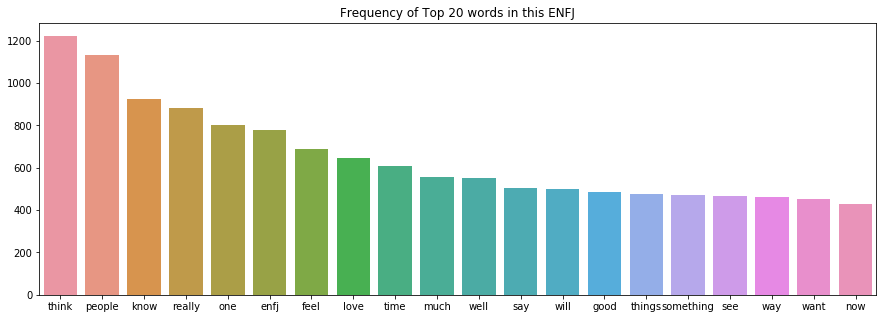

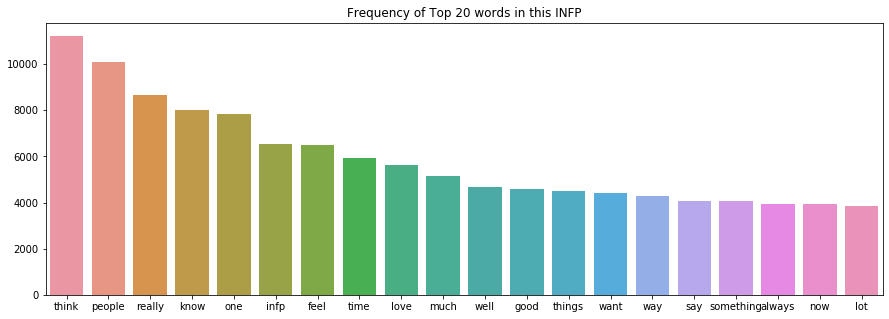

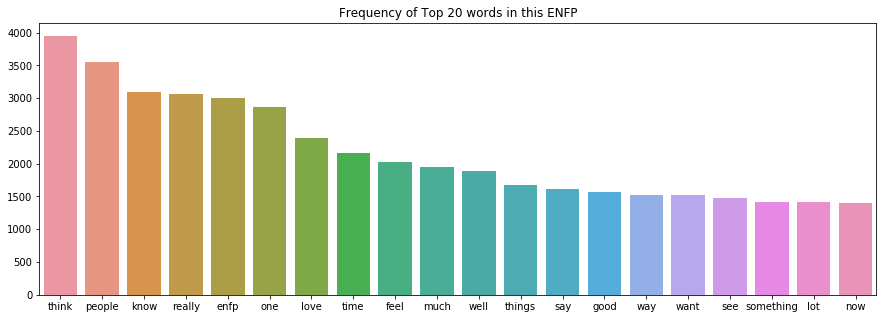

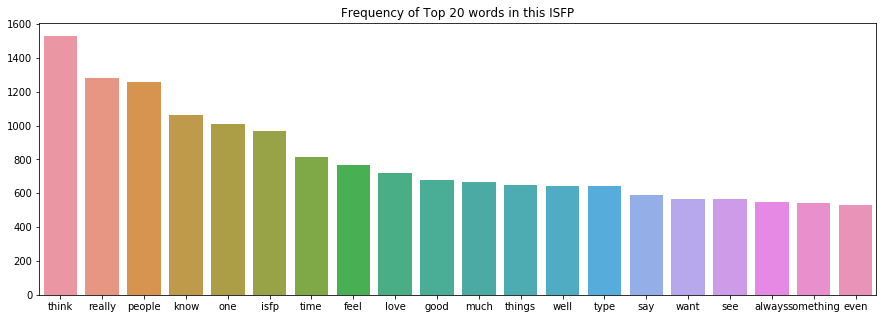

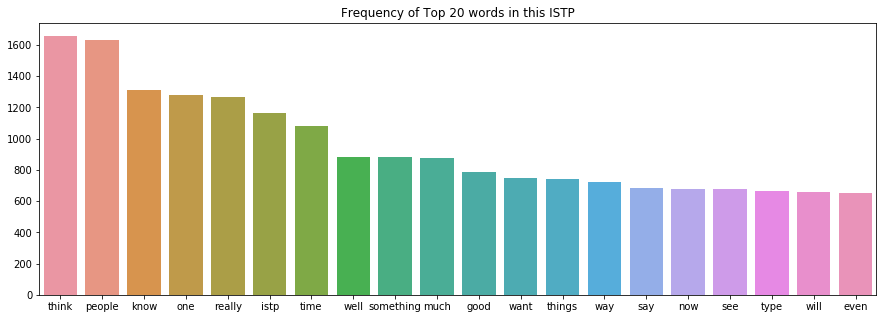

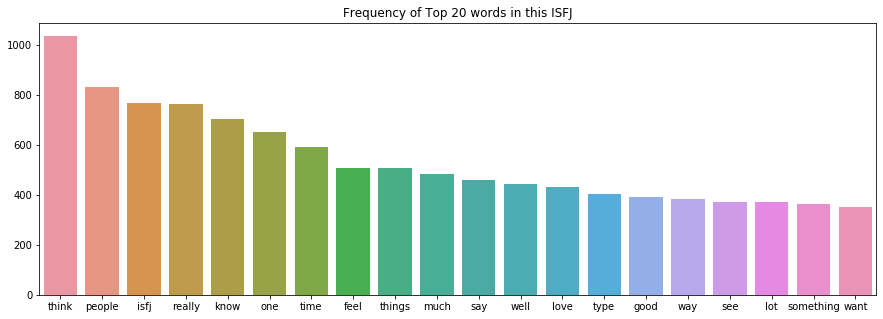

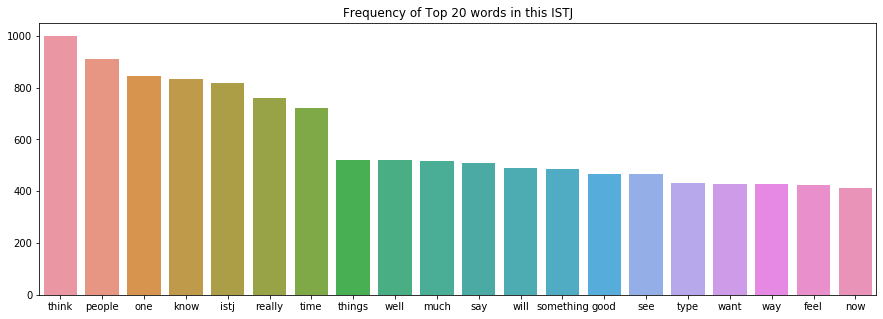

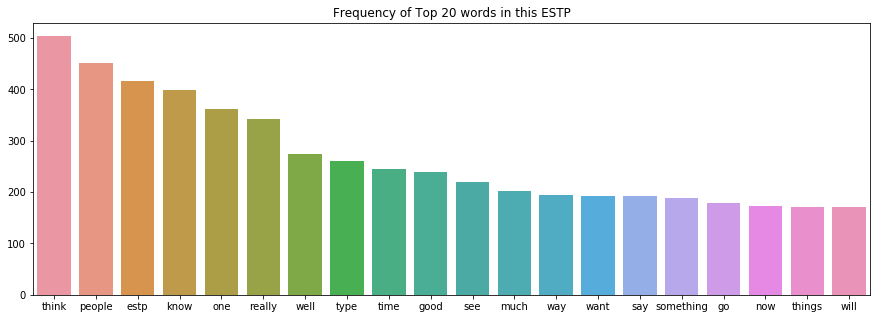

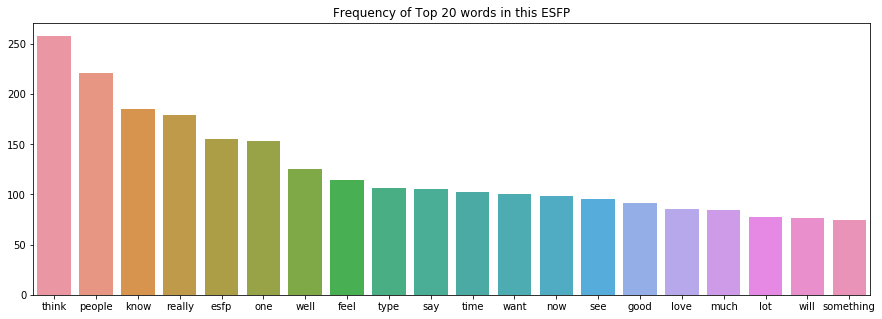

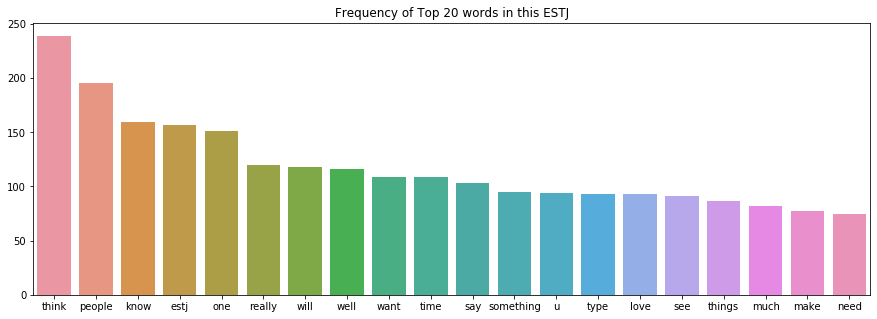

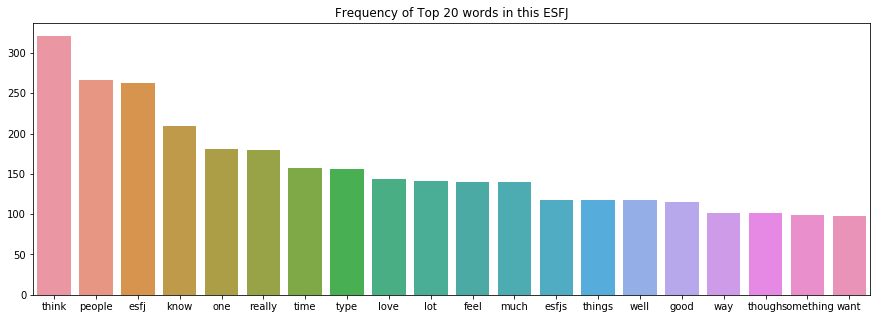

In [37]:
categories = df.type.unique()
for i in categories:
    category_top20(df,i)

In [38]:
def Word_Cloud(df, category):
    fig , ax1 = plt.subplots(1 , 1 , figsize = [10,8])
    dx = df[df.type == category]['clean_posts']
    wordcloud1 = WordCloud(background_color = 'black' , width = 600 , height = 400).generate(" ".join(dx))
    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Wordcloud for posts '+ category , fontsize = 20)

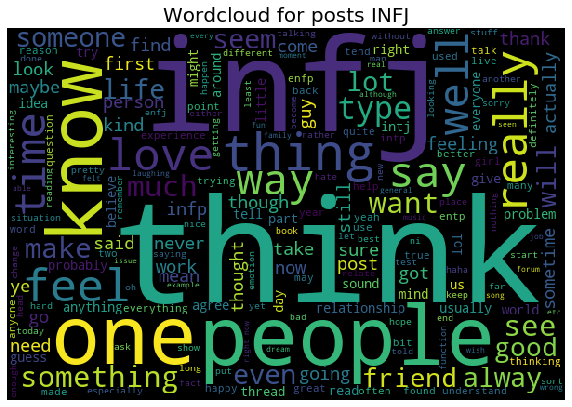

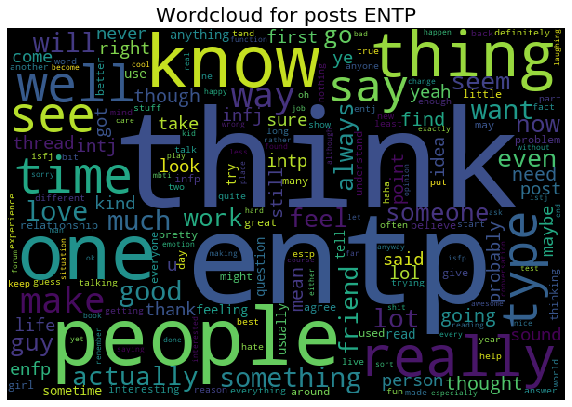

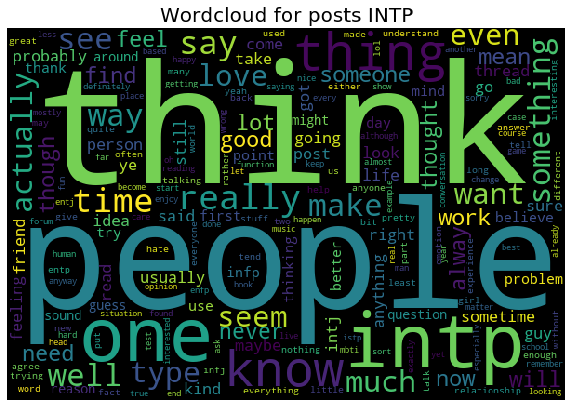

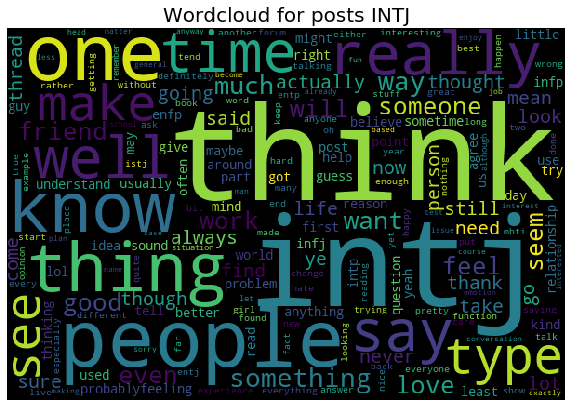

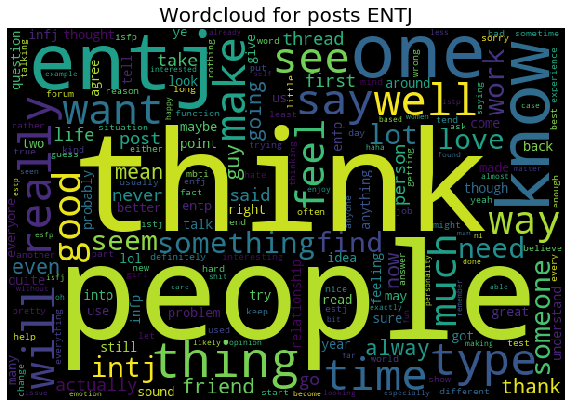

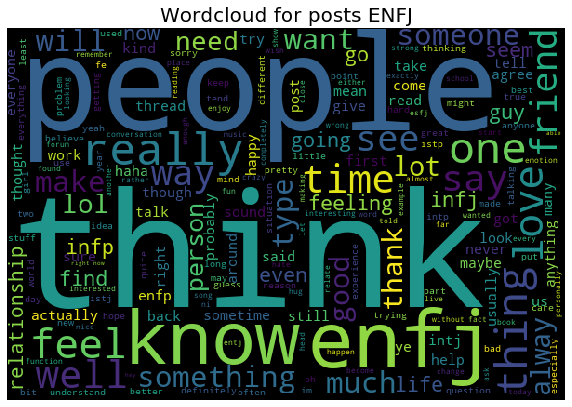

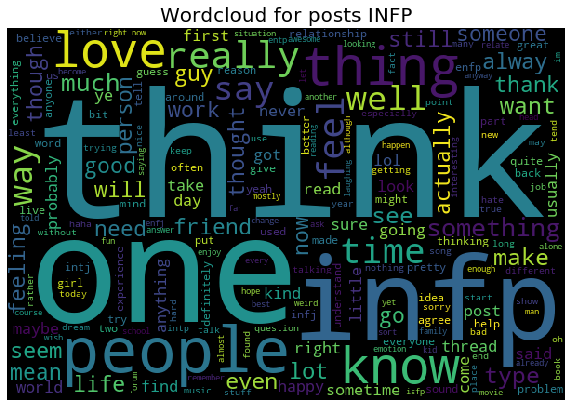

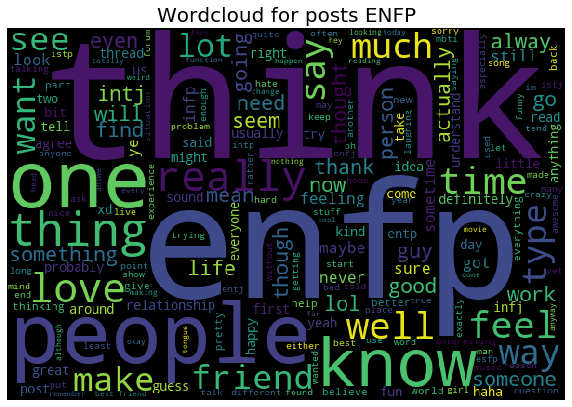

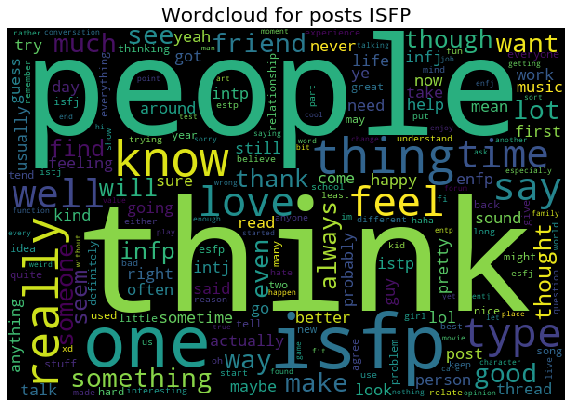

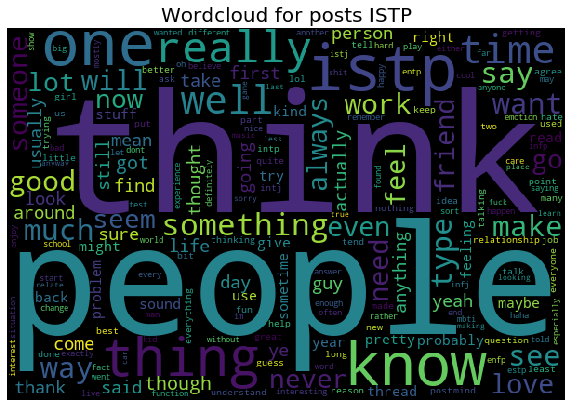

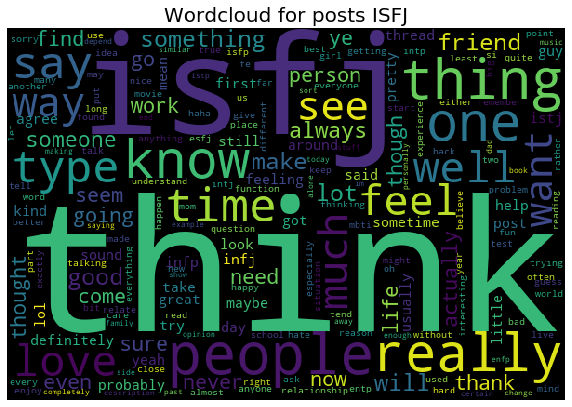

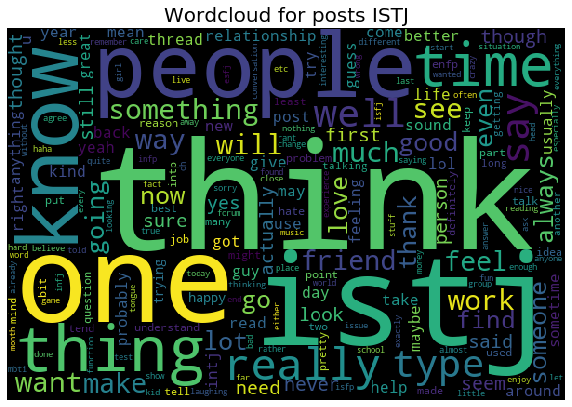

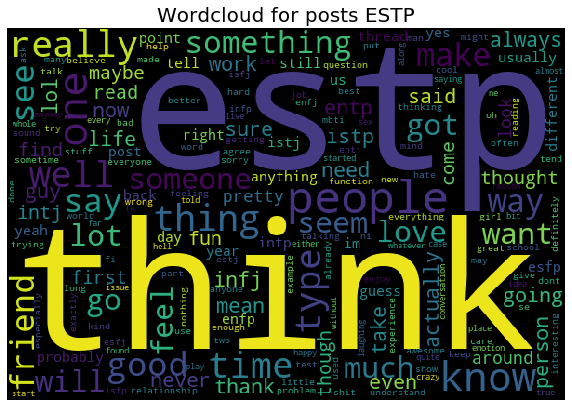

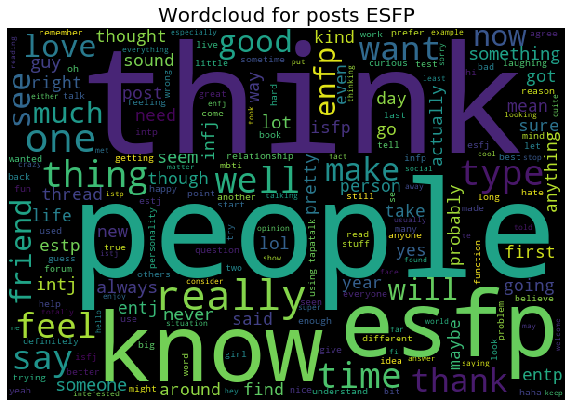

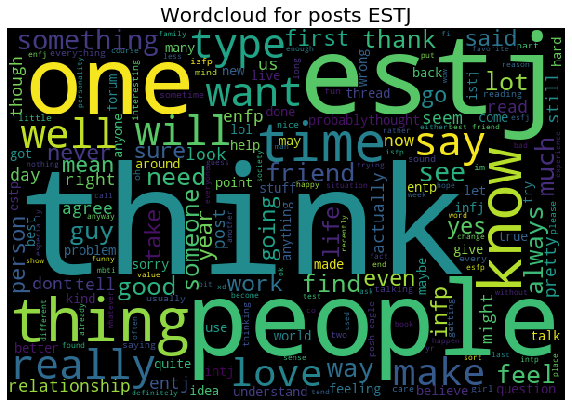

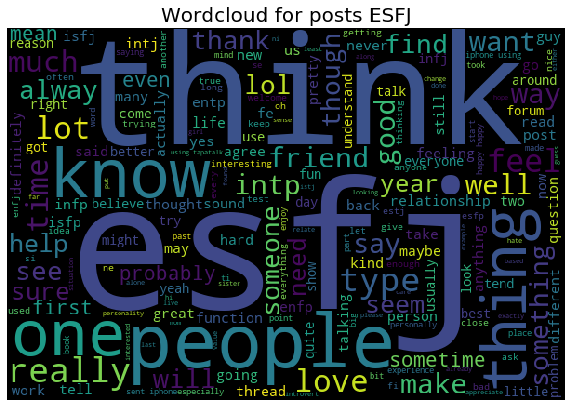

In [39]:
for i in categories:
    Word_Cloud(df,i)

## Machine Learning Models

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [41]:
data = df[['clean_posts','type']]
encoder = LabelEncoder()
data['type_enc'] = encoder.fit_transform(data.type)
data.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


clean_posts  type  type_enc
0  ' intj moments sportscenter top ten plays pran...  INFJ         8
1  'i'm finding lack posts alarming sex boring po...  ENTP         3
2  'good one _____ course say know blessing curse...  INTP        11
3  'dear intp enjoyed conversation day esoteric g...  INTJ        10
4  'you're fired another silly misconception appr...  ENTJ         2

In [49]:
code_personality = {}

for index,row in data.iterrows():
    code_personality[row['type_enc']]=row['type']

print(code_personality)

{8: 'INFJ', 3: 'ENTP', 11: 'INTP', 10: 'INTJ', 2: 'ENTJ', 0: 'ENFJ', 9: 'INFP', 1: 'ENFP', 13: 'ISFP', 15: 'ISTP', 12: 'ISFJ', 14: 'ISTJ', 7: 'ESTP', 5: 'ESFP', 6: 'ESTJ', 4: 'ESFJ'}


We are going to use **clean_posts** to predict personality type. First, we split data into train set and test set. The train set contains 75% of data points and the test set contains 25% of data points.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_posts'],data['type_enc'],test_size=0.25,random_state=53)

The X_train, X_test are sets of posts which are not the form that we can feed Machine Learning models. In order to apply Machine Learning models we need to have features expressed in numbers for X. We have to use **CountVectorizer** is used to convert the text documents to a vector of term/token counts.

We set min_df=0.1 and max_df=0.9. It means we only consider words that appear in more than 10% of the posts and less than 90% of the posts. It makes sense here, since we do not want to take into account words that only appear in a few posts neither words that appear in almost every posts.

In [44]:
count_vectorizer = CountVectorizer( min_df=0.1, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

**count_train** and **count_test** are sparse matrices whose columns are selected words and rows are posts. Each entry in the matrix is the frequency that the word (column) appear in the post(row).

With min_df=0.1 and max_df=0.9, we are going to apply the models(Logistic Regression, K Nearest Neighbors, Support Vector Machine, Decision Tree, Random Forest, Stochastic Gradient Descent and Naive Bayes) to the count_train and evaluate the accuracy of these models on count_test.

### Models

Now we are ready to train a model and predict the required solution.
Here, 

y is value of target feature 'type_enc'

and

$X$ is sparse matrix whose columns are selected words and rows are posts. Each entry in the matrix is the frequency that the word (column) appear in the post(row).

which we will use to fit a machine learning model and predict value of y. 

There are so many predictive modelling algorithms out there to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification problem. We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a labeled dataset. With these two criteria - Supervised Learning plus Classification, we can narrow down our choice of models to a few. These include:

* K_Nearest_Neighbor
<br>

* Logistic Regression
<br>

* Support Vector Machine
<br>

* Stochastic Gradient Descent
<br>

* Random Forest
<br>

* Decision Tree
<br>

* Naive Bayes
<br>



### Metrics
Beside the accuracy, we are going to use precison, recall, f1-score, AUC-ROC to evaluate our models.

**Precision**
$$precision= \frac{TP}{TP+FP}$$


High Precision indicates an example labelled as positive is indeed positive (a small number of FP).

**Recall**
$$Recall= \frac{TP}{TP+FN}$$


High Recall indicates the class is correctly recognized (a small number of FN).

**F-measure**

Since we have two measures (Precision and Recall) it helps to have a measurement that represents both of them.

$$F-measure = \frac{2*Recall*Precision}{Recall+Precision}$$

**AUC-ROC**

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is plotted with TPR(True positive rate) against the FPR(False Positive rate) where TPR is on y-axis and FPR is on the x-axis.

AUC-ROC: the area under the curve ROC. It tells how much model is capable of distinguishing classes. Higher the AUC, better the model is at distinguishing between classes.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [47]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(kernel='linear',probability=True),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(loss='modified_huber', shuffle=True,random_state=101),
    "Naive Bayes": MultinomialNB()
}

In [48]:
for name, model in classifiers.items():
    model.fit(count_train,y_train)
    accuracy = accuracy_score(y_test,model.predict(count_test))
    print('{} Accuracy: {}'.format(name,accuracy))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisiticRegression Accuracy: 0.541263254956201
KNearest Accuracy: 0.36053480866758875
Support Vector Classifier Accuracy: 0.5601659751037344
DecisionTreeClassifier Accuracy: 0.47118487782388196
Random Forest Classifier Accuracy: 0.5882895343476257
Stochastic Gradient Descent Accuracy: 0.532964499769479
Naive Bayes Accuracy: 0.6021207929921623


In [50]:
from scipy import interp
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [51]:
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [52]:
for name, model in classifiers.items():
    model.fit(count_train,y_train)
    report_with_auc = class_report(
    y_true=y_test, 
    y_pred=model.predict(count_test), 
    y_score=model.predict_proba(count_test))
    print("{} Report:".format(name))
    print(report_with_auc)
    print('\n')
    print('\n')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisiticRegression Report:
             precision    recall  f1-score  support    pred       AUC
0             0.333333  0.297297  0.314286     37.0    33.0  0.824996
1             0.509554  0.459770  0.483384    174.0   157.0  0.873895
2             0.480769  0.396825  0.434783     63.0    52.0  0.880244
3             0.429412  0.470968  0.449231    155.0   170.0  0.858833
4             0.666667  0.285714  0.400000      7.0     3.0  0.724197
5             0.400000  0.222222  0.285714      9.0     5.0  0.786163
6             0.750000  0.272727  0.400000     11.0     4.0  0.806218
7             0.714286  0.344828  0.465116     29.0    14.0  0.880180
8             0.599469  0.585492  0.592398    386.0   377.0  0.861503
9             0.632530  0.681818  0.656250    462.0   498.0  0.877571
10            0.434783  0.476190  0.454545    252.0   276.0  0.828767
11            0.567867  0.617470  0.591631    332.0   361.0  0.870200
12            0.611111  0.423077  0.500000     52.0    36.0  0

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Classifier Report:
             precision    recall  f1-score  support    pred       AUC
1             0.804348  0.425287  0.556391    174.0    92.0  0.541071
2             0.714286  0.079365  0.142857     63.0     7.0  0.492723
3             0.632812  0.522581  0.572438    155.0   128.0  0.524317
8             0.623874  0.717617  0.667470    386.0   444.0  0.434883
9             0.513174  0.885281  0.649722    462.0   797.0  0.464520
10            0.596154  0.615079  0.605469    252.0   260.0  0.518138
11            0.627737  0.777108  0.694482    332.0   411.0  0.455751
13            1.000000  0.041096  0.078947     73.0     3.0  0.547370
14            1.000000  0.040000  0.076923     50.0     2.0  0.459599
15            0.800000  0.259740  0.392157     77.0    25.0  0.384424
avg / total   0.601283  0.591978  0.541866   2024.0  2024.0  0.912980




Stochastic Gradient Descent Report:
             precision    recall  f1-score  support    pred       AUC
0             0.2

### More about Naive Bayes 

Out of all models we applied, Naive Bayes turns out to be the best model. We would like to look deeper into Naive Bayes model. We vary the values of min_df and max_df and apply the best model we have(Naive Bayes).

In [53]:
from numpy import arange
min_df_sets = arange(0.01,.2,0.01)
Accuracy_sets=[]
for n in min_df_sets:
    count_vectorizer = CountVectorizer( min_df=n, max_df=1-n)
    count_train = count_vectorizer.fit_transform(X_train.values)
    count_test = count_vectorizer.transform(X_test.values)
    nb_classifier = MultinomialNB()
    nb_classifier.fit(count_train,y_train)
    Accuracy = accuracy_score(y_test,nb_classifier.predict(count_test))
    Accuracy_sets.append(Accuracy)

<function matplotlib.pyplot.show(*args, **kw)>

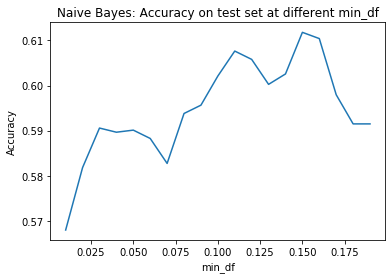

In [54]:
plt.plot(min_df_sets,Accuracy_sets)
plt.xlabel("min_df")
plt.ylabel("Accuracy")
plt.title("Naive Bayes: Accuracy on test set at different min_df")
plt.show

In [55]:
print(Accuracy_sets)

[0.5680036883356385, 0.5818349469801752, 0.5905947441217151, 0.5896726602120793, 0.5901337021668972, 0.5882895343476257, 0.582757030889811, 0.5938220378054403, 0.5956662056247118, 0.6021207929921623, 0.6076532964499769, 0.6058091286307054, 0.6002766251728907, 0.6025818349469801, 0.611802674043338, 0.6104195481788843, 0.5979714153988013, 0.5915168280313509, 0.5915168280313509]


The highest accuracy is 0.612 when we only consider words appear in more than 15% and less than 85% of the posts.

In [56]:
# Best model
count_vectorizer_best = CountVectorizer( min_df=0.15, max_df=0.85)
count_train_best = count_vectorizer_best.fit_transform(X_train.values)
count_test_best = count_vectorizer_best.transform(X_test.values)
nb_classifier_best = MultinomialNB()
nb_classifier_best.fit(count_train_best,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predict Personality of Kaggle Users

We are going to apply our best model to find out Kaggle users personality based on their comments on Kaggle. The ForumMessages.csv is available on Kaggle at https://www.kaggle.com/kaggle/meta-kaggle?select=ForumMessages.csv

Let's first load all the Kaggle's comments.

In [57]:
kaggle = pd.read_csv('/Users/vnguyenair/Desktop/springboard/vy_capstone2_Personality_Prediction/ForumMessages.csv')

In [58]:
kaggle.head()

Id  ForumTopicId  PostUserId             PostDate  ReplyToForumMessageId  \
0  14             7         478  05/02/2010 14:37:35                    NaN   
1  15             8         638  05/04/2010 09:32:54                    NaN   
2  16             8         650  05/04/2010 09:32:54                    NaN   
3  17             8         478  05/04/2010 09:32:54                    NaN   
4  28            16         368  05/12/2010 04:39:30                    NaN   

                                             Message  Medal MedalAwardDate  
0  Now that we have a handful of algorithms that ...    NaN            NaN  
1  The goal of the game is to answer the question...    NaN            NaN  
2  Look at the description in the Data section:<b...    NaN            NaN  
3  <blockquote><p>The dataset contains many diffe...    NaN            NaN  
4  Here are some papers that analyze Eurovision v...    NaN            NaN

And now replace all the missing message by a comment with no word.

In [59]:
kaggle['Message'] = kaggle['Message'].fillna('')

Now we combine all comments posted by the same Post User Id and create a dataframe with 2 columns **PostUserId** and **Message**.

In [60]:
kaggle_join = kaggle.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [61]:
kaggle_join.head()

PostUserId                                            Message
0          62  Vateesh, thanks for alerting us to this. Can y...
1         368  Here are some papers that analyze Eurovision v...
2         381  <p>Hi Bdol.</p>\r\n<p>Please comment out the l...
3         387  <p>From an economic perspective let's look at ...
4         389  <pre><code>import bokeh\nfrom bokeh.plotting i...

In [62]:
kaggle_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141963 entries, 0 to 141962
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PostUserId  141963 non-null  int64 
 1   Message     141963 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


We add a column **Message_length** representing the length of the message.

In [63]:
kaggle_join['Message_length']= kaggle_join['Message'].apply(lambda x: len(x.split()))

Since our model is build on data where the majority of posts are longer than 500 words,it works the best for post longer than 500 words. We only look at Kaggle user whose combined message is longer than 500 words.

In [66]:
kaggle_join_len = kaggle_join.loc[kaggle_join.Message_length > 500,:]

In [67]:
kaggle_join_len.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 1 to 141870
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PostUserId      9235 non-null   int64 
 1   Message         9235 non-null   object
 2   Message_length  9235 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 288.6+ KB


By restricting the length of the message, we reduce the number of messages we are going to examinate from 141963 to 9235.

We now apply the preprocessing to the messages and use the clean_messages to feed our best model.

In [68]:
kaggle_join_len['clean_messages'] = kaggle_join_len['Message'].apply(lambda x: text_preprocessing(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
kaggle_join_len.head()

PostUserId                                            Message  \
1         368  Here are some papers that analyze Eurovision v...   
2         381  <p>Hi Bdol.</p>\r\n<p>Please comment out the l...   
3         387  <p>From an economic perspective let's look at ...   
6         393  <p>[quote=Josette_BoozAllen;155818]</p>\n\n<p>...   
7         412  <p>Are there any criteria around model validit...   

   Message_length                                     clean_messages  
1           32612  papers analyze eurovision voting patterns migh...  
2           28821  hi bdol please comment line dbclear error main...  
3             526  economic perspective look demand supply declar...  
6             789  thomasseleck aws credits opportunity will anno...  
7             789  criteria around model validity nbsp e model ne...

In [71]:
count_kaggle = count_vectorizer_best.transform(kaggle_join_len['clean_messages'].values)
pred_kaggle = nb_classifier_best.predict(count_kaggle)
count_all = np.unique(pred_kaggle, return_counts=True)
print(count_all)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 261,  271,  608,   11,   30,  564,  754,    3,  263,   83, 3934,
        734,    8,   16, 1175,  520]))


In [72]:
print('Personality code')
print(code_personality)

Personality code
{8: 'INFJ', 3: 'ENTP', 11: 'INTP', 10: 'INTJ', 2: 'ENTJ', 0: 'ENFJ', 9: 'INFP', 1: 'ENFP', 13: 'ISFP', 15: 'ISTP', 12: 'ISFJ', 14: 'ISTJ', 7: 'ESTP', 5: 'ESFP', 6: 'ESTJ', 4: 'ESFJ'}


In [79]:
per_type=[]
for n in range(0,16):
    per_type.append(code_personality[n])
    
print (per_type)

['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']


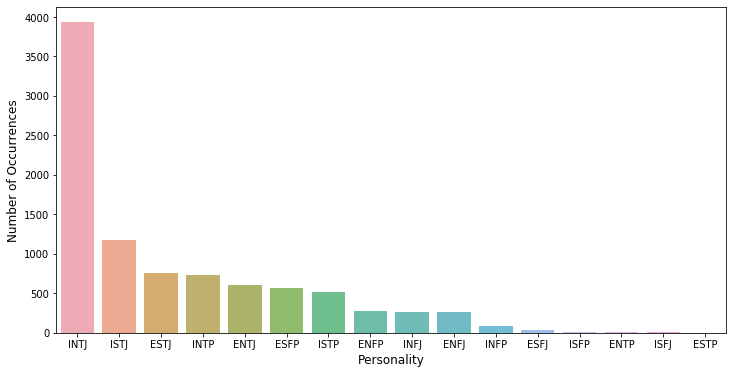

In [80]:


pred_df = pd.DataFrame({'personality': per_type, 'count': count_all[1]},
                      columns=['personality', 'count'], index=None)
pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(pred_df['personality'], pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

## Predict Personality of Popular People

There are two US political features that seem to stand for the opposite point of view: President Donald Trump and previous president Barack Obama. We will collect their posts and use our best model to predict thier personality.

In [81]:
social_posts = pd.read_excel('/Users/vnguyenair/Desktop/springboard/vy_capstone2_Personality_Prediction/Social_Posts.xlsx')

In [82]:
social_posts.head()

Name                                              Posts
0  Barack Obama  Michelle and I have been spending a lot of tim...
1  Donald Trump   No doubt many people told him his vision wasn...

In [83]:
social_posts['posts_length']=social_posts['Posts'].apply(lambda x: len(x.split()))

In [84]:
social_posts.head()

Name                                              Posts  \
0  Barack Obama  Michelle and I have been spending a lot of tim...   
1  Donald Trump   No doubt many people told him his vision wasn...   

   posts_length  
0           766  
1          1146

In [85]:
social_posts['clean_posts'] = social_posts['Posts'].apply(lambda x: text_preprocessing(x))

In [86]:
social_posts.head()

Name                                              Posts  \
0  Barack Obama  Michelle and I have been spending a lot of tim...   
1  Donald Trump   No doubt many people told him his vision wasn...   

   posts_length                                        clean_posts  
0           766  michelle spending lot time together past month...  
1          1146  doubt many people told vision wasn t possible ...

In [87]:
count_train_best = count_vectorizer_best.fit_transform(X_train.values)
count_exam = count_vectorizer_best.transform(social_posts['clean_posts'].values)

In [88]:
nb_classifier_best.predict(count_exam)

array([9, 9])

In [89]:
code_personality[9]

'INFP'

They are both predict to have INFP (Introversion-Intuition-Feeling-Perception) personality type.